## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_gene.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/Gene/gene.pt"
Data = torch.load(path)
Data

{'x': tensor([[12.2066,  8.5495, 10.7969,  ...,  8.4967,  8.5979,  8.8691],
         [ 9.6155,  8.9314,  9.5201,  ...,  9.6052, 11.1579, 10.5243],
         [ 6.2624, 10.6610,  8.8817,  ...,  6.8272,  6.2315,  6.5671],
         ...,
         [ 6.0040, 11.8118, 10.3843,  ...,  7.5903, 12.6739, 12.8235],
         [ 8.8085, 12.8148, 15.4529,  ...,  9.6657, 13.1217, 10.3099],
         [ 7.3143, 13.6116, 12.9968,  ...,  8.7592,  9.8862,  9.2184]]),
 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,
           4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
           8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
          10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
          14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19,
          19, 19, 19, 20, 20, 20, 20, 20, 20, 2

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 65
Number of features: 60
Number of classes: 3
Number of edges: 266
Average node degree: 4.09
Number of training nodes: 40
Number of testing nodes: 15
Training node label rate: 0.62


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/Gene/p_links_gene.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([65, 65])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116


# Developing our own model (making our own message passing layers).

# BGATConv
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph(p_link) and $\Theta$ is learnable parameter.

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 60, out_channels = 10)
        self.conv2 =  BGATConv(10,5)
        self.conv3 =  BGATConv(5, 3)


        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.torch.tanh(h)
        return h
        
model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(60, 10)
  (conv2): BGATConv(10, 5)
  (conv3): BGATConv(5, 3)
)
tensor([[ 0.2697, -0.9984,  0.9625],
        [ 0.1263, -0.7821,  0.5417],
        [ 0.2983, -0.9348,  0.7711],
        [ 0.2597, -0.5222,  0.3410],
        [ 0.2763, -0.9923,  0.9185],
        [ 0.3068, -0.9977,  0.9570],
        [ 0.2553, -0.9134,  0.7354],
        [ 0.3748, -0.9997,  0.9865],
        [ 0.3972, -0.9966,  0.9456],
        [ 0.4356, -1.0000,  0.9967],
        [ 0.2334, -0.9870,  0.8922],
        [ 0.2968, -0.9951,  0.9391],
        [ 0.1970, -0.8826,  0.6854],
        [ 0.0937, -0.9396,  0.7404],
        [ 0.1096, -0.9440,  0.7370],
        [ 0.3570, -0.9998,  0.9867],
        [ 0.3823, -0.9950,  0.9359],
        [ 0.4214, -0.9989,  0.9666],
        [ 0.3511, -0.9992,  0.9767],
        [ 0.2540, -0.9971,  0.9493],
        [ 0.2391, -0.9963,  0.9328],
        [ 0.4274, -1.0000,  0.9962],
        [ 0.2366, -0.9857,  0.8850],
        [ 0.3825, -0.5219,  0.4167],
        [ 0.2414, -0.

# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",3)).set(title = "Gene expression data T-SNE projection before training (BGAT)")

Embedding shape: [65, 3]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


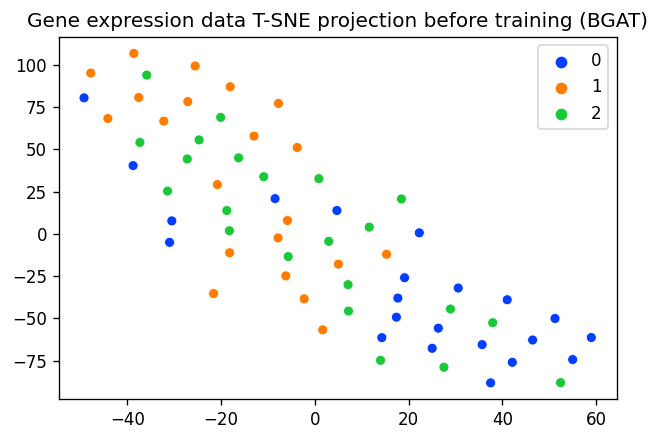

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model. 

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005, weight_decay = 5e-4)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1,101):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())




  

  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

1 Train Loss: 1.243 | val Loss: 1.390
2 Train Loss: 1.224 | val Loss: 1.372
3 Train Loss: 1.177 | val Loss: 1.338
4 Train Loss: 1.131 | val Loss: 1.326
5 Train Loss: 1.108 | val Loss: 1.297
6 Train Loss: 1.105 | val Loss: 1.223
7 Train Loss: 1.103 | val Loss: 1.176
8 Train Loss: 1.098 | val Loss: 1.142
9 Train Loss: 1.091 | val Loss: 1.103
10 Train Loss: 1.088 | val Loss: 1.086
11 Train Loss: 1.094 | val Loss: 1.082
12 Train Loss: 1.093 | val Loss: 1.082
13 Train Loss: 1.089 | val Loss: 1.100
14 Train Loss: 1.082 | val Loss: 1.125
15 Train Loss: 1.078 | val Loss: 1.141
16 Train Loss: 1.073 | val Loss: 1.151
17 Train Loss: 1.066 | val Loss: 1.151
18 Train Loss: 1.058 | val Loss: 1.145
19 Train Loss: 1.054 | val Loss: 1.147
20 Train Loss: 1.052 | val Loss: 1.149
21 Train Loss: 1.049 | val Loss: 1.154
22 Train Loss: 1.043 | val Loss: 1.170
23 Train Loss: 1.042 | val Loss: 1.170
24 Train Loss: 1.042 | val Loss: 1.140
25 Train Loss: 1.037 | val Loss: 1.104
26 Train Loss: 1.032 | val Loss: 1

# Visualize train loss and val loss.

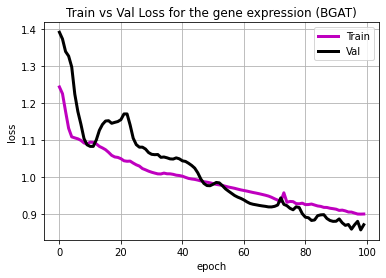

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the gene expression (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 80.00


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",3)).set(title = "Gene expression data T-SNE projection after training (BGAT)")

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


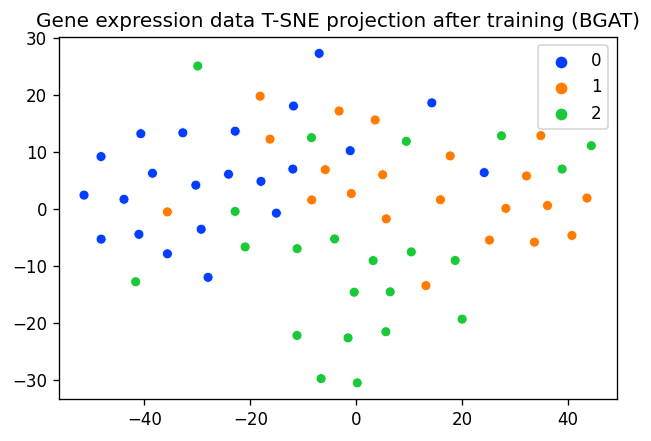

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred = out.argmax(dim=1)
pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 2, 2, 2])

In [ ]:
pred = pred[Data["test_mask"]] 

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,2,2
7,2,2
8,2,1
9,2,0


<ipython-input-23-8d81dfc6e44f>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


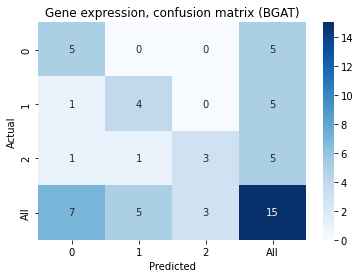

In [ ]:
confusion_matrix = pd.crosstab(data['y_Actual'], data['y_Predicted'], rownames=['Actual'], colnames = ['Predicted'], margins = True)
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues")
ax = plt.axes()
ax.set_title('Gene expression, confusion matrix (BGAT)')
plt.show()